In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import json
import urllib.request
import torch
import numpy as np
import random
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from torchvision import models, transforms
from PIL import Image
from collections import Counter
import os
import matplotlib.pyplot as plt
import random
from collections import Counter
import cv2

# Load ImageNet class labels
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
with urllib.request.urlopen(url) as f:
    imagenet_labels = json.load(f)

# Initialize PyTorch ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = models.resnet50(pretrained=True)
resnet_model = resnet_model.eval().to(device)

# Image preprocessing for PyTorch model
normalize_preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define directory with images
img_dir = '/content/drive/MyDrive/485Fashion'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
def apply_clahe(img_array):
    lab = cv2.cvtColor(img_array, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

def resize_with_aspect_ratio(img, target_size=(300, 300)):
    h, w = img.shape[:2]
    scale = min(target_size[0] / h, target_size[1] / w)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    delta_w, delta_h = target_size[1] - new_w, target_size[0] - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    return cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

def remove_colored_bubbles(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_color = np.array([0, 35, 35])
    upper_color = np.array([360, 40, 45])
    mask = cv2.inRange(hsv, lower_color, upper_color)
    mask_inv = cv2.bitwise_not(mask)
    background_only = cv2.bitwise_and(img, img, mask=mask_inv)
    background_only = cv2.GaussianBlur(background_only, (3, 3), 0)
    return background_only

def apply_edge_detection(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, threshold1=50, threshold2=150)
    return cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

def preprocess_image(img_path, target_size=(300, 300), use_clahe=True, mask_bubbles=False, use_edge_detection=False):
    img = cv2.imread(img_path)
    img = resize_with_aspect_ratio(img, target_size)
    if mask_bubbles:
        img = remove_colored_bubbles(img)
    if use_clahe:
        img = apply_clahe(img)
    if use_edge_detection:
        img = apply_edge_detection(img)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img_rgb)

# PyTorch preprocessing to normalize the image for ResNet
normalize_preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
# Define the feature extraction function
def extract_features(img_dir, model, preprocess):
    features = []
    img_names = []
    for img_file in os.listdir(img_dir):
        img_path = os.path.join(img_dir, img_file)
        img = Image.open(img_path).convert("RGB")
        img_tensor = preprocess(img).unsqueeze(0).to(device)

        with torch.no_grad():
            feature = model(img_tensor).cpu().numpy().squeeze()
            features.append(feature)
            img_names.append(img_file)
    return np.array(features), img_names

# Extract features and standardize
features, img_names = extract_features(img_dir, resnet_model, normalize_preprocess)
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Clustering
agglo = AgglomerativeClustering(n_clusters=15, linkage='ward')
agglo_labels = agglo.fit_predict(features)

# Generate descriptive labels using predictions
def generate_labels_from_predictions(cluster_labels, img_names, img_dir, resnet_model, n_samples=32, top_n=5):
    cluster_labels_dict = {}
    for cluster in range(max(cluster_labels) + 1):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        sample_indices = random.sample(list(cluster_indices), min(n_samples, len(cluster_indices)))
        predictions = []

        for idx in sample_indices:
            img_path = os.path.join(img_dir, img_names[idx])
            img = Image.open(img_path).convert("RGB")
            img_tensor = normalize_preprocess(img).unsqueeze(0).to(device)

            with torch.no_grad():
                preds = resnet_model(img_tensor)
                top_predictions = torch.topk(preds, top_n).indices.squeeze(0).tolist()
                predicted_labels = [imagenet_labels[i] for i in top_predictions]
                predictions.extend(predicted_labels)

        # Assign a combined label for this cluster
        common_labels = [label for label, _ in Counter(predictions).most_common(2)]
        cluster_label = "/".join(common_labels)
        cluster_labels_dict[cluster] = cluster_label

    return cluster_labels_dict

# Generate descriptive labels for each cluster
agglo_cluster_labels_dict = generate_labels_from_predictions(agglo_labels, img_names, img_dir, resnet_model)


print("Agglomerative Clustering Descriptive Labels:")
for cluster, label in agglo_cluster_labels_dict.items():
    print(f"Cluster {cluster}: {label}")

Agglomerative Clustering Descriptive Labels:
Cluster 0: gown/sarong
Cluster 1: sarong/gown
Cluster 2: pajamas/suit
Cluster 3: trench coat/cloak
Cluster 4: gown/sarong
Cluster 5: buckle/sandal
Cluster 6: scarf/sweatshirt
Cluster 7: face powder/neck brace
Cluster 8: trench coat/miniskirt
Cluster 9: T-shirt/swimming cap
Cluster 10: scarf/fur coat
Cluster 11: trench coat/suit
Cluster 12: kimono/sarong
Cluster 13: slip-on shoe/sandal
Cluster 14: gown/hoop skirt


In [10]:
# Display images with their cluster labels
def display_images_with_labels(cluster_labels, img_names, img_dir, cluster_labels_dict, num_samples=30):
    selected_indices = random.sample(range(len(img_names)), num_samples)
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(selected_indices):
        img_path = os.path.join(img_dir, img_names[idx])
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        cluster = cluster_labels[idx]
        label = cluster_labels_dict.get(cluster, "Noise" if cluster == -1 else "Unknown")  # Handle noise points

        plt.subplot(6, 5, i + 1)
        plt.imshow(img_rgb)
        plt.title(f"Cluster {cluster}: {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# Display images with descriptive cluster labels
def display_images_with_cluster_descriptions(cluster_labels, img_names, img_dir, cluster_labels_dict, num_samples=20):
    selected_indices = random.sample(range(len(img_names)), num_samples)
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(selected_indices):
        img_path = os.path.join(img_dir, img_names[idx])
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        cluster = cluster_labels[idx]
        descriptive_label = cluster_labels_dict.get(cluster, "Unknown")

        plt.subplot(4, 5, i + 1)
        plt.imshow(img_rgb)
        plt.title(f"Cluster {cluster}: {descriptive_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

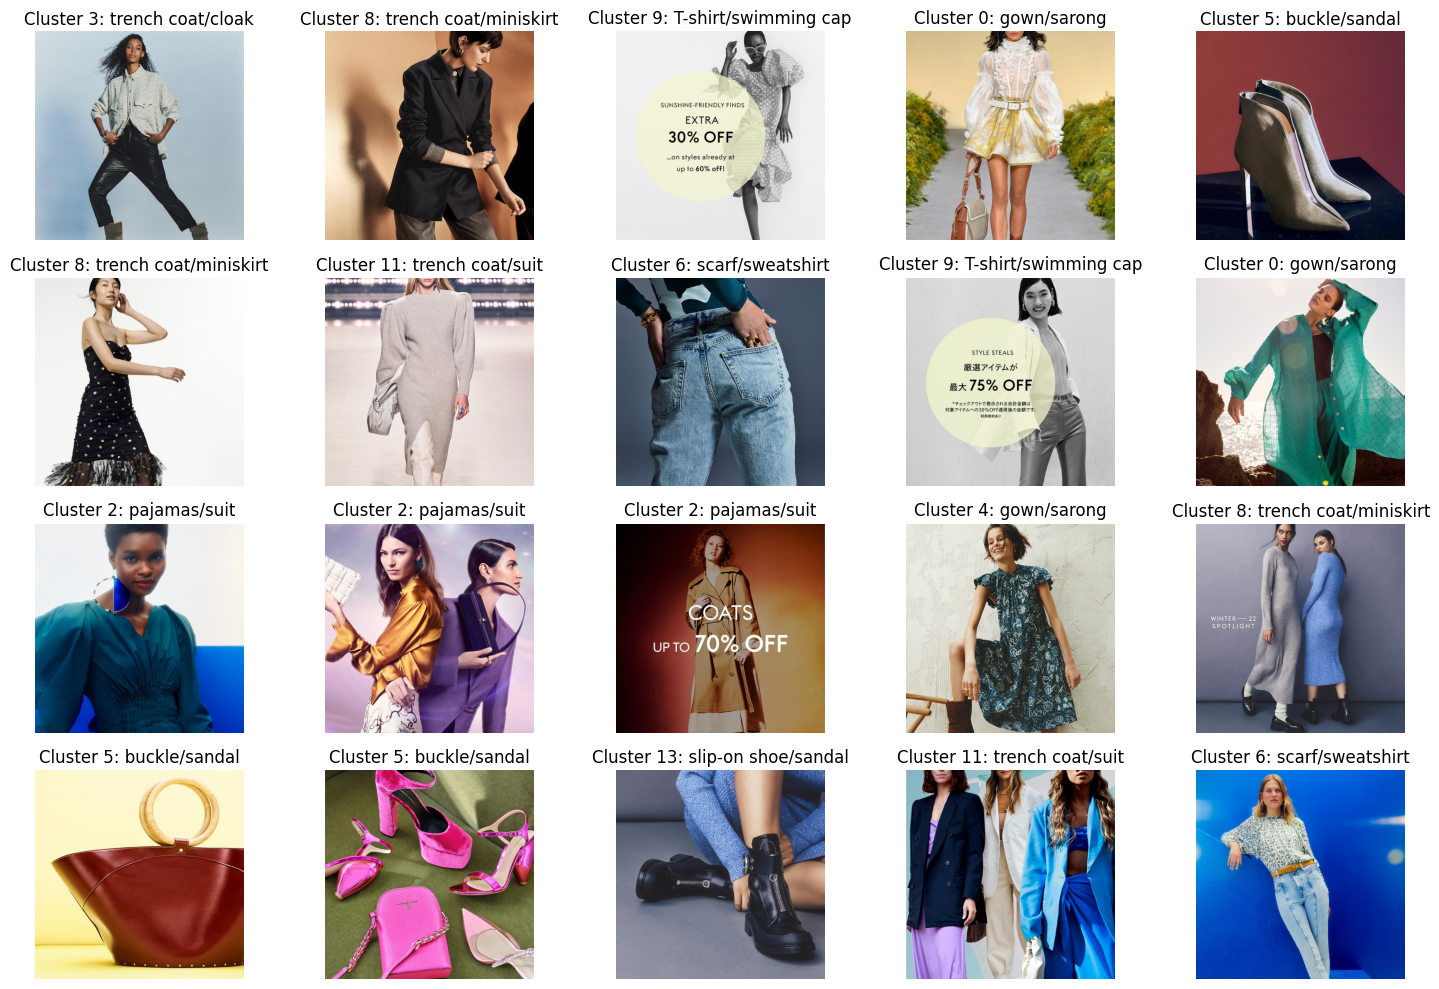

In [12]:
display_images_with_cluster_descriptions(agglo_labels, img_names, img_dir, agglo_cluster_labels_dict)
